<a href="https://colab.research.google.com/github/Arnabis5/Group_A_UWAFTHackathon_2024/blob/main/Another_copy_of_OnlyGym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Distance: 4020.32 meters
Steps Taken: 5026


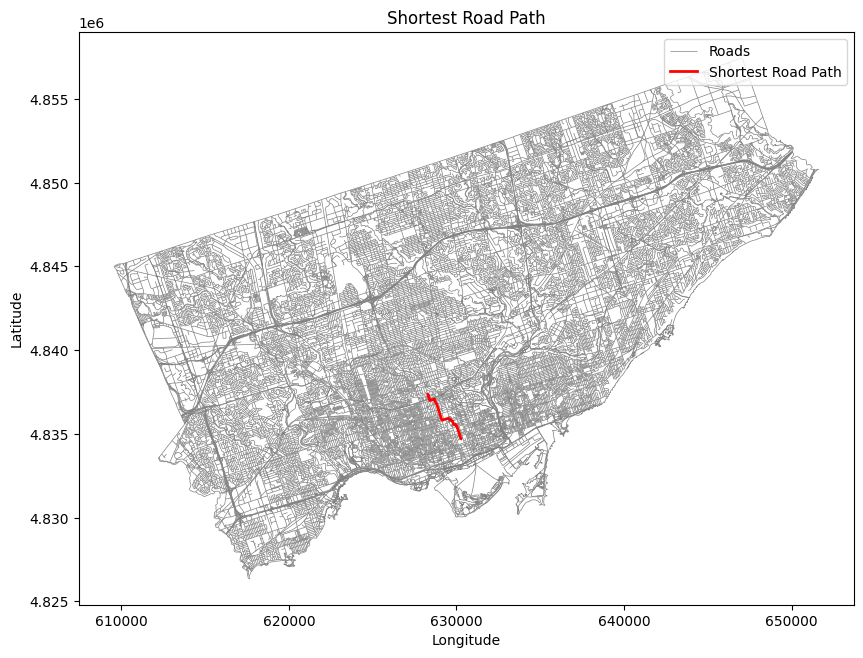

In [ ]:
import os
import zipfile
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math
#Imports all the libraries

zip_path_road = "/content/Centreline - Version 2 - 4326.zip"
zip_path_subway = "/content/ttc-subway-shapefile-wgs84.zip"

# Extract all data from the zipfiles
with zipfile.ZipFile(zip_path_road, 'r') as zip_ref:
    zip_ref.extractall("/content/CentreLine")
with zipfile.ZipFile(zip_path_subway, 'r') as zip_ref:
    zip_ref.extractall("/content/TTCLines")

roads = gpd.read_file("/content/CentreLine/Centreline - Version 2 - 4326.shp")
subway_lines = gpd.read_file("/content/TTCLines/TTC_SUBWAY_LINES_WGS84.shp")

roads = roads.to_crs(epsg=32617) #looks into the data file and assigns the value road
subway_lines = subway_lines.to_crs(epsg=32617) #looks into the data file and assigns the value subway_lines

G_road = nx.Graph() #creates graphs to represent road and transit networks
G_transit = nx.Graph()

def add_edges_from_linestring(graph, df, weight_factor=1): #the purpose of this function is to format the graphs. this function runs a loop multiple time to grind the grid
    for _, row in df.iterrows():
        line = row.geometry
        if isinstance(line, LineString):
            for i in range(len(line.coords) - 1):
                start = line.coords[i]
                end = line.coords[i + 1]
                distance = Point(start).distance(Point(end)) * weight_factor
                graph.add_edge(start, end, weight=distance)

add_edges_from_linestring(G_road, roads, weight_factor=1)
add_edges_from_linestring(G_transit, subway_lines, weight_factor=0.5)

def get_nearest_node(graph, point): #This function finds the nearest node,
    nearest_node = None
    min_distance = float('inf')
    for node in graph.nodes: # goes through each node on the grid and checks the distance between the node and a certain location
        dist = Point(node).distance(point)
        if dist < min_distance: #compares the distance of the current node with the distance of the node closest to the location
            nearest_node = node
            min_distance = dist #once it
    return nearest_node #returns the value of the nearest node

def find_shortest_path(graph, start_point, end_point): # This finds the shorts path between when the user starts and ends
    start_node = get_nearest_node(graph, start_point) # Uses the get nearest node function to find an exact location
    end_node = get_nearest_node(graph, end_point)
    path = nx.dijkstra_path(graph, start_node, end_node, weight='weight')
    return path #returns path

def plot_paths(graph_road, path_road, roads):
    plt.figure(figsize=(10, 10))

    # Plot roads
    roads.plot(ax=plt.gca(), color="gray", linewidth=0.5, label="Roads")

    # Plot shortest road path
    path_road_coords = [Point(coord) for coord in path_road]
    road_line = LineString(path_road_coords)
    x, y = road_line.xy
    plt.plot(x, y, color="red", linewidth=2, label="Shortest Road Path")

    # Add legend and labels
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Shortest Road Path")
    plt.show()
# Define start and end points
start_point = Point(-79.3841, 43.6534)  # ROM
end_point = Point(-79.4094, 43.6780)    # Queen's Park
start_point_proj = gpd.GeoSeries([start_point], crs="EPSG:4326").to_crs(roads.crs).iloc[0]
end_point_proj = gpd.GeoSeries([end_point], crs="EPSG:4326").to_crs(roads.crs).iloc[0]

# Find the shortest path
shortest_path_road = find_shortest_path(G_road, start_point_proj, end_point_proj)

def calculate_total_distance_and_steps(path_coords, stride_length):
    total_distance = 0
    for i in range(len(path_coords) - 1):
        start = Point(path_coords[i])
        end = Point(path_coords[i + 1])
        total_distance += start.distance(end)
    steps_taken = math.ceil(total_distance / stride_length)  # Round up to the nearest step
    return total_distance, steps_taken

shortest_path_road = find_shortest_path(G_road, start_point_proj, end_point_proj)

# Calculate total distance and steps
stride_length = 0.8  # Step length in meters
total_distance, steps_taken = calculate_total_distance_and_steps(shortest_path_road, stride_length)

# Print the results
print(f"Total Distance: {total_distance:.2f} meters")
print(f"Steps Taken: {steps_taken}")

# Plot the shortest path
plot_paths(G_road, shortest_path_road, roads)
